Auctions without auctioneers - letting bidders themselves run the show, through homomorphic encryption  
============
-----



#  Summary 


The goal of this notebook is to provide a prototype illustrating how homomorphic encryption would allow mechanism design schemes that do not rely on the "mythical central planner". **For instance auctions ran without an auctioneer acting as trusting third party, but organized by the participating parties themselves**. One can then use such a decentralized auction to automate and improve OTC auctions, for example those operating under BWIC ("bids wanted in competition"), which are **prone to misreporting and collusion/conflicts of interest** (*see for instance "Public Sector Pension Investment Board of Canada v. Saba Capital Management"*).



#  The use of encryption as a solution to "*misreporting and collusion/conflicts of interest*" (from Professor Townsend's lecture 4 notes) :


**For the first part ("*misreporting*"), encryption allows ledgers as financial accounts to be altered with transfers done in a secure way**, which can even ensure privacy (if designed to be so). **For the second part ("*conflicts*"), with encryption we can implement optimized contracts and solutions to multi-agent mechanism design problems**.

In fact, the idea and practice of encryption is ancient, with applications similar to contemporary analogues. **Let us thus describe here through two introductory and historical examples** - that of Mesopotamian clay tokens in sealed envelopes as invoices to accompany the shipment of goods, and that of split English tally sticks to convey debt in such a way as to allow it to be passed through third parties for presentation - **the use of encryption as a solution first to "misreporting" (through Mesopotamian clay tokens) and "conflicts" (through English split tally sticks)**.


- **Encryption and misreporting : the example of *the Mesopotamian clay tokens* :**

The idea behind the clay tokens is that tampering by third parties becomes evident by comparing the actual shipment to the envelope. In cases of cheating attempt by the shipper, either the shipments of goods does not match the tokens in the sealed envelope, or the envelop itself is broken. 


- **Encryption and collusion/conflicts of interest: the example of *the split English tally sticks* :**

The idea behind the willow tally sticks is that the uniquely grained wood branches are spit into matching halves as records of the same underlying transaction. One of the halves remains with the issuer/borrower and the other half given to the original lender investor. The latter circulated in the public as money before redemption, with redemption by a third party extinguishing the original debt, but only when the halves matched (the wood's natural cryptographic function thus guaranteeing that **for each half there's only one and one unique other half, thus preventing problems like double spending** - since reproducing prefectly the natural grain of a split wood branch was considered a hard enough problem).

In this case collusion and conflict of interest can be thought for instance as two people (the "colluded parties") who jointly issue tally sticks, with some arbitrary value on them, without intent of redeeming them back together (so, in a way, printing themselves "free debt/money"). These two parties will then try to exchange both halves of the split tally to get themselves free money or goods.

However, by making the two halves of the stick of different lengths - the longer part being called stock and being given to the party which had advanced money (or other items) to the receiver, and the shorter portion of the stick being called foil and being given to the party which had received the funds or goods - and by making these two halves very distinct from each other - so that potential "buyers" can recognize wether the offered half is a debt or a credit - these "freely" generated split tally sticks are prevented from getting "free money or goods". Hence here it is the e

Furthermore, let's also note that the untampering property of split tally stick - similar to the clay token example above - also prevents price/quantity manipulation variants, as after one tally stick has been split there's no way to modify the value of only one of its half without modifying the value of the other half.  



#  Systems of "*trust and cryptography*"


In each of these ancient systems, there are thus **elements of trust - first in the sense of *fulfilling a commitment***, for instance in the fact that the borrower will repay the loan to original investor or verified third party. But this commitment problem is furthermore mixed with the need for encryption to deal with nefarious behavior from non-trusted parties in between, that is, surreptitiously pilfering goods or the counterfeiting of promises to pay. **The need of trust thus also further covers the fair functioning of the system** (no misreporting and no possibility of conflict). 

**It is only once *both* elements of trust have been secured that *contracts themselves* can be exchanged on some kind of anonymous dual matching exchanges**, which allows human and village economies to grow into financial and mercantilist economies (USE ELEMENTS OF SME REPORT HERE TO HIGHLIGHT THIS POINT).

**One could thus think of these mechanism design settings as hybrid or mixed systems, with both trust and cryptography**. The trust part is enforced through social conventions (servicing one's debt as a moral matter), while the misreporting and conflict prevention part are solved with cryptography. 

Hybrid systems are likewise used today, for instance through institutional arrangements (think of **trusted third parties operating the dual matching engines, guaranteeing true reporting and fair matching while preserving the privacy of sensible informations that are needed in the process**).



## Issues of "*trust and cryptography*" in the case of existing OTC auctions :


Let's first note **the conflict between the need of *preserving privacy* and the need of a *guarantee of true reporting and conflict-proof process*** . Indeed, in institutional arrangement involving trusted third parties, a door remains open for the *trusted* third party to behave in an unfair or an untruthful way.

Institutional safeguards such as audits have been historically built to prevent this (see literature around village economies as in Townsend, *Medieval village economy* book), but in the case of OTC schemes **the fact that the trusted third party operating the scheme is *also* an active participant on one side of the dual matching engine** (for instance BWIC auctions are often organized by entities looking to sell the asset being the object of the auction) provides strong incentives for misreporting and conflicts of interests.

A classical example in current BWIC auctions - ran over the telephone - would be for the seller of the asset in question (also the organizer of the auction) to tell buyer A : "I prefer you my friend, but buyer B just offered a *slightly* higher price, so if you can just make *sooome* effort the good is yours", and vice versa with buyer B to prop the price up. This entire trick resides in the fact that neither buyer A or B can check the bid of the other buyer, hence have to trust the seller/organizer of the auction.

Hence the need for an auction scheme which provides to the side (of the dual matching exchange) *not organizing or running the auction* ways to solve the trust issues of potential misreporting of potential conflicts.




## Homomorphic encryption, and privacy-preserving audits to make existing mechanism design conflict-proof


- **Homomorphic encryption :**

Homomorphic encryption is **a form of encryption that allows computation on ciphertexts** (encrypted messages), generating an encrypted result which, when decrypted, matches the result of the operations as if they had been performed on the plaintext. I.e., if we perform function f on a message m has been homomorphically encrypted into the ciphertext h(m), we have the equivalence $h^{-1}(f(h(m)))= f(m)$ , or equivalently $f(h(m))=h(f(m))$ .

For example, one can thus perform operations such as addition on underlying messages m1 and m1, or encrypt each to keep them private, sum the encrypted values, and if desired, decipher to get the original sum. 
In short the spaces of underlying messages and encrypted messages are isomorphic , allowing computations on privately-preserved data.  


- **Public/private key encryption :** 

With a public key for encryption and a private key for decryption  of  a message, algorithms on designated spaces make it virtually impossible to decipher an encrypted message without the private key that  was a key in generating it.

However, the public key can be used for authentification and to guarantee integrity and commitment of a message ; in that case, the private key is used to generate a digital signature for a message, and such a signature can be verified by using the signer's corresponding public key. In this way the recipient knows who sent the message. Specifically, the receiver can verify the origin of the message (authentication), that the message has not been modified since it was signed (integrity), and the sender cannot falsely claim that they have not signed the message (non repudiation). To be stressed:  that these are extremely useful properties, all without the receiver ever knowing the private key (hence the content of the encrypted messages).

- **Homomorphic encryption + public/private key encryption :**

Homomorphic encryption with public/private key encryption can thus be used for privacy-preserving outsourced storage and computation. 

Let's for instance go back to our BWIC auction example, in which the seller of an asset organizes an auction scheme. However, **to limit the seller's incentives to misreport, each buyer's bid will be encrypted by him using his unique secret key, to prevent anyone else (especially the seller/organizer of the auction, who agrees to not possess each buyer's individual secret key) from tampering with it** - in a similar fashion as the Mesopotamian clay token example before.  

Furthermore, the organizer of this BWIC auction agrees to ***only provide* the matching (or ranking) operation of this auction, performed homomorphically on top of each buyer's encrypted bid**. The encrypted bids thus protect buyers' privacy in both keeping it untampered with, and potentially by keeping them anonymous (if the public/private keys are allocated randomly to each participating agent) to reduce potential conflict of interest and collusion between the organizer of the auction and some participants.

- **Extension to new possible solutions in mechanism design problem, through a hybrid private-but-contributing-state of information**

Let's note furthermore that in the previously described auction scheme, the secrets, the underlying messages before encryption, need never be revealed to the agent or institution performing the matching/ranking operation (if the scheme allows buyers' to keep their secret private keys secret to all but themselves), which can enhance the protection of privacy and could allow for the design of more sophisticated mechanism design scheme allowing hydrid public-private states of information (as **encrypted inputs kept absolutely private can *still* contribute to operations performed homomorphically on top of them, which would provide previously unaccessible information to the mechanism designer/planner - and hence improved computable solutions.)**







## Two misreporting and conflict-proof prototype schemes here, that can be adapted at your workplace :

This notebook provides **two** prototypes of such a misreporting, conflict-proof schemes.

The first is **entirely self-contained in this notebook**, so that you can see both encryption-decryption code for buyers, sellers, and for the matching engine performing the homomorphic encryption. You can then copy-paste and adapt these pieces of code to be run in any fashion between your buyers/sellers, on an architecture/server of your collective choice.

The second is more sophisticated, and **show how the homomorphic encryption scheme can generate keys and signatures that can be sent from one user interface (the notebook here) to another (the server performing the homomorphic encryption** - thus not seeing any of the content of the encrypted messages, but still performing a function which will give the correct output once each party decrypts its resulting message). Here the server will be one coded in Flask, with the entire code accessible at github.something... and hosted by Google cloud - but it could be any server that you, your buyers/sellers agree upon (for instance a server only performing homomorphic encryption as described in the section above, and collectively managed by buyers, or with an audit door for them, would prevent any misreporting or conflict of interest).

The good sold can be anything. We just provided here the prototype to organize such a BWIC auction for selling this good, but without the negative incentives current schemes introduce.


## The homomorphic encryption scheme used here 


**Homomorphic encryption refers to a kind of encryption in which some computation on ciphertexts produces an encryption of the desired computation on the plaintexts** (i.e. f(Enc(messages)) = Enc(f(messages)), in which f can be additive, multiplicative, or more sophisticated functions). 

The Paillier encryption scheme used here is for instance homomorphic over the operation of addition. **Namely, given pk, Enc(pk, m1), Enc(pk, m2) one can efficiently compute Enc(pk, m1 + m2)**. *(see Paillier, Pascal (1999). "Public-Key Cryptosystems Based on Composite Degree Residuosity Classes". EUROCRYPT. Springer. pp. 223–238. doi:10.1007/3-540-48910-X_16)*


<img src="Screen Shot 2020-05-27 at 6.55.54 AM.png" />
<img src="Screen Shot 2020-05-27 at 6.55.08 AM.png" />

## First prototype : the self-contained code all accessible here :

In [1]:
# Importing the Paillier encryption library from https://python-paillier.readthedocs.io

from phe import paillier

# Importing a graphic toolbox to plot the distributions in BWIC auctions
import matplotlib.pyplot as plt


In [2]:
# Now we are starting to build the public and private keys

public_key, private_key = paillier.generate_paillier_keypair()
 
# If we’re going to have lots of private keys lying around, then we can use a keyring on which to store our PaillierPrivateKey instances:
keyring = paillier.PaillierPrivateKeyring()
keyring.add(private_key)

In [3]:
# Let's decide how many buyers are participating to this auction. 
# For now let's say 3. If you want more you can just copy paste the code below by adding the number of player 4, player 5, etc

# Let's create for all 3 of them a public key and private key pair :

public_key1, private_key1 = paillier.generate_paillier_keypair(keyring)
public_key2, private_key2 = paillier.generate_paillier_keypair(keyring)
public_key3, private_key3 = paillier.generate_paillier_keypair(keyring)

# And the list that will receive their three bids :

secret_number_list = [None] * 3

# We are now starting to enter the bids for the good. 

Here below the cells are collapsable, so that each of your 3 bidding buyer can "open" a cell, input their private values in it, then "close" the cell to prevent other players to easily see the value it contains

In [4]:
# Call your bidding buyer 1 and let him enter his bid here (without looking at his value !)

bid_from_player_1 = 13.141592653;

# Let's store that bid in the list of bids
secret_number_list[0] = bid_from_player_1

In [5]:
# Now call your bidding buyer 2 and let him enter his bid here (without looking at his value !)

bid_from_player_2 = 10;

# Let's store that bid in the list of bids
secret_number_list[1]=bid_from_player_2

In [6]:
# Now call your bidding buyer 3 and let him enter his bid here (without looking at his value !)

bid_from_player_3 = 8;

# Let's store that bid in the list of bids
secret_number_list[2]=bid_from_player_3

In [7]:
# Let's now encrypt everything

encrypted_number_list = [public_key.encrypt(x) for x in secret_number_list]
print(encrypted_number_list)
# Now the list of bids has been encrypted using the public key ! It can for instance be revealed without any outside agent being able to decrypt it

[<phe.paillier.EncryptedNumber object at 0x10f210350>, <phe.paillier.EncryptedNumber object at 0x117452c10>, <phe.paillier.EncryptedNumber object at 0x10f1f59d0>]


# A "decentralized auctioneer"

This party does not have access to the private keys, and typically performs operations on supplied encrypted data. It can be a server hosted by the seller, a server hosted by one (or more) of the buyers, or a combination of both. Buyers/seller just need to make sure that this party execute correctly the function assigned to it (here, the ranking) - which is the only thing it can mess (since it doesn't have access to the private keys, it can't tamper with the messages, nor with the identities of the messages senders - which can be kept anonymous if the keys are generated anonymously - for instance via random assignment of public/private key pairs at the start, or any other scheme).

Once this party has received some EncryptedNumber instances, it can perform basic mathematical operations supported by the Paillier encryption, such as:

- Addition of an EncryptedNumber to a scalar
- Addition of two EncryptedNumber instances
- Multiplication of an EncryptedNumber by a scalar

In [8]:
#Let's print out the encrypted number for instance to see that they are indeed "meaningless"

encrypted_number_list

In [9]:
# Let's now see homomorphically (i.e. performing the comparison function on the encrypted data) which one of the bids is higher

bid1_vs_bid2 = encrypted_number_list[0] - encrypted_number_list[1]

# You can see that the result is also encrypted, hence meaningless for the outside agent looking at it
print(bid1_vs_bid2)

## With homomorphic encryption, a piece of code (or a "smart contract") can now perform the role of the auctioneer

Such a code does not have access to the private keys, but can still perform operations on supplied encrypted data, and hence tell all participating agents which one has the highest bid (if in a single round auction), or provide some information between rounds before the bid updating step in a multiround auction (the distribution of bids at each round, the distribution *without the highest bid* at each round...)...

This guarantees truthfulness of the auctioneer, full and transparent reporting of the informations that has been decided to be revealed at the end of each round, and better privacy for the bidders on the rest.

### Example of a single round first-price auction based on the previous 3 bids :

In [10]:
if private_key.decrypt(bid1_vs_bid2)>0:
    bid2_vs_bid3 = encrypted_number_list[0] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        print('bidder 1 won the auction')
    else:
        print('bidder 3 won the auction')
        
else:
    bid2_vs_bid3 = encrypted_number_list[1] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        print('bidder 2 won the auction')
    else:
        print('bidder 3 won the auction')
    
        

bidder 1 won the auction


### Example of a multiround BWIC auction based on the previous 3 bids :

Each round of the BWIC auction will be based on two steps : first the submission (or the update) of each one's bid, second the revelation of the distribution of the bids **without the highest bid**.

#### Use the cell below for the submission (or the update) of each one's bid at each round

Here below the cells are collapsable, so that each of your 3 friends can "open" a cell, input their private values in it, then "close" the cell to prevent other players to easily see the value it contains

In [15]:
# Call your friend player 1 and let him enter his bid here (without looking at his value !)

bid_from_player_1 = 3.141592653;

# Let's store that bid in the list of bids
secret_number_list[0] = bid_from_player_1

In [16]:
# Now call your friend player 2 and let him enter his bid here (without looking at his value !)

bid_from_player_2 = 10.141592653;

# Let's store that bid in the list of bids
secret_number_list[1] = bid_from_player_2

In [17]:
# Finally call your friend player 3 and let him enter his bid here (without looking at his value !)

bid_from_player_3 = 23.141592653;

# Let's store that bid in the list of bids
secret_number_list[2] = bid_from_player_3

#### Use the cell below to produce the distribution of the bids without the highest bid at the end of each round

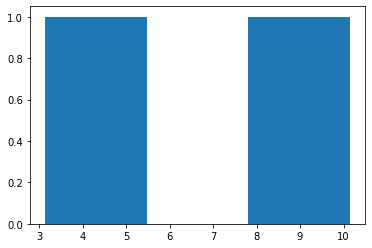

In [20]:
encrypted_number_list = [public_key.encrypt(x) for x in secret_number_list]

bid_distribution_without_highest = [None] * 2
bid1_vs_bid2 = encrypted_number_list[0] - encrypted_number_list[1]

if private_key.decrypt(bid1_vs_bid2)>0:
    bid2_vs_bid3 = encrypted_number_list[0] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        
        #if we were in a single round then print('bidder 1 won the auction') 
        bid_distribution_without_highest[0] = secret_number_list[1]
        bid_distribution_without_highest[1] = secret_number_list[2]
    else:
        #if we were in a single round then print('bidder 3 won the auction')
        bid_distribution_without_highest[0] = secret_number_list[0]
        bid_distribution_without_highest[1] = secret_number_list[1]
        
else:
    bid2_vs_bid3 = encrypted_number_list[1] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        #if we were in a single round then print('bidder 2 won the auction')
        bid_distribution_without_highest[0] = secret_number_list[0]
        bid_distribution_without_highest[1] = secret_number_list[2]
    else:
        #if we were in a single round then print('bidder 3 won the auction')
        bid_distribution_without_highest[0] = secret_number_list[0]
        bid_distribution_without_highest[1] = secret_number_list[1]
        
plt.hist(bid_distribution_without_highest, bins = 3)
plt.show()


#### Then you can re iterate with your friends over the past two steps, until convergence to a clear winner

## The second prototype : creating bids from this notebook, and sending them to a server (which you as a buyer can audit)


In [1]:
# TO DO